In [14]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [16]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

In [17]:
len(train_ds.anchor_data), len(train_ds.anchor_labels), len(eval_ds.anchor_data), len(eval_ds.anchor_labels)

(29997, 29997, 4999, 4999)

In [18]:
BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity


loss_history = []
accuracy_history = []

def train(model, criterion, optimizer, train_loader, valid_loader, epochs, save_path="models/model"):
    best_val_loss = float('inf')  # Initialize with infinity
    
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)    
    
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        val_loss = 0
        
        for inputs, labels in train_loader:
            
            input_anchor, input_pos, input_neg = inputs
            # label_anchor, label_pos, label_neg = labels
            
            input_anchor = input_anchor.to(device)
            input_pos = input_pos.to(device)
            input_neg = input_neg.to(device)
            
            emb_anchor = model(input_anchor)
            emb_pos = model(input_pos)
            emb_neg = model(input_neg)
            
            loss = criterion(emb_anchor, emb_pos, emb_neg)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            
        loss_history.append(loss.item())    
        
        scheduler.step(val_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        embeddings = []
        targets = []
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                input_anchor, input_pos, input_neg = inputs
                label_anchor, label_pos, label_neg = labels
                
                batch_emb, batch_lab = [], []
                
                input_anchor = input_anchor.to(device)
                input_pos = input_pos.to(device)
                input_neg = input_neg.to(device)
                
                emb_anchor = model(input_anchor)
                emb_pos = model(input_pos)
                emb_neg = model(input_neg)
                
                # embeddings.extend(emb_anchor)
                batch_emb.extend(emb_pos.cpu())
                batch_emb.extend(emb_neg.cpu())
                
                # labels.extend(label_anchor)
                batch_lab.extend(label_pos.cpu().tolist())
                batch_lab.extend(label_neg.cpu().tolist())
                
                embeddings.extend(batch_emb)
                targets.extend(batch_lab)
                
                
                loss = criterion(emb_anchor, emb_pos, emb_neg)
                val_loss += loss.item()
        
        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)
        
        for i in range(len(embeddings)):
            embeddings[i] = embeddings[i].detach().numpy()
            
        
        embeddings = np.array(embeddings)
        targets = np.array(targets)
        
        # Get cosine similarity for all embeddings
        similarity_matrix = cosine_similarity(embeddings)
        
        # Fill diagonal with inf
        np.fill_diagonal(similarity_matrix, -np.inf)
        
        # Find the index of max sim for each embedding
        most_similar_indices = np.argmax(similarity_matrix, axis=1)
        
        # Extract the labels of the most similar items
        predicted_labels = [targets[i] for i in most_similar_indices]
        
        
        # Get number of correct predictions
        # n_correct = sum(1 for true_label, predicted_label in zip(labels, predicted_labels) if true_label == predicted_label)
        n_correct = sum(1 for true, pred in zip(targets, predicted_labels) if true == pred)
        
        print("Number of correct matches: ", n_correct)

        val_acc = 100 * (n_correct / len(embeddings))

        accuracy_history.append(val_acc)
        
        print(f"Validation accuracy: {val_acc:0.3f}%")
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch}")
            print("Model saved with validation loss:", best_val_loss)


### 2. Get model & train

In [20]:
import os

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

if os.path.exists("models/resnet50.pt"):
    model.load_state_dict(torch.load("models/resnet50.pt"))

model = model.to(device)


c:\Users\sebas\miniconda3\envs\trust-me\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sebas\miniconda3\envs\trust-me\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# import os

# model = models.resnet50(pretrained=True)
# print(model)
# model.fc = torch.nn.Identity()

# if os.path.exists("models/resnet50.pt"):
#     model.load_state_dict(torch.load("models/resnet50.pt"))

# model = model.to(device)


In [22]:
LR = 1e-1

n_epochs = 20

criterion = torch.nn.TripletMarginLoss(margin=1, p=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [23]:
train_ds.anchor_data[0].shape

torch.Size([1, 64, 64])

In [24]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, "models/resnet50")

Number of correct matches:  9811
Validation accuracy: 98.130%
Epoch 1/20, Train Loss: 0.1255, Valid Loss: 0.0639
Model saved with validation loss: 0.0639195565110559
Number of correct matches:  9796
Validation accuracy: 97.980%
Epoch 2/20, Train Loss: 0.0322, Valid Loss: 0.0845
Number of correct matches:  9816
Validation accuracy: 98.180%
Epoch 3/20, Train Loss: 0.0284, Valid Loss: 0.0535
Model saved with validation loss: 0.05354513583859061
Number of correct matches:  9766
Validation accuracy: 97.680%
Epoch 4/20, Train Loss: 0.0161, Valid Loss: 0.0655
Number of correct matches:  9825
Validation accuracy: 98.270%
Epoch 5/20, Train Loss: 0.0220, Valid Loss: 0.0511
Model saved with validation loss: 0.05106787264916548
Number of correct matches:  9815
Validation accuracy: 98.170%
Epoch 6/20, Train Loss: 0.0130, Valid Loss: 0.0511
Number of correct matches:  9833
Validation accuracy: 98.350%
Epoch 7/20, Train Loss: 0.0158, Valid Loss: 0.0322
Model saved with validation loss: 0.032249215776

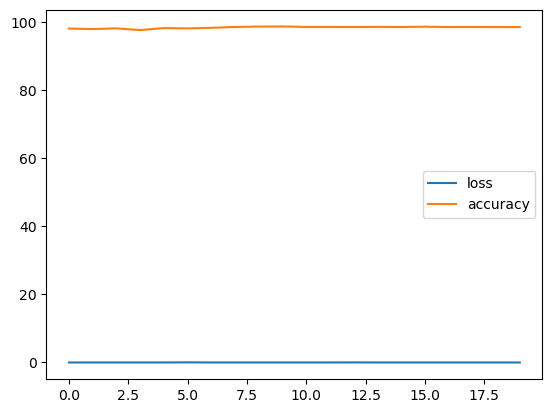

In [32]:
import matplotlib.pyplot as plt


plt.plot(loss_history, label="loss")
plt.plot(accuracy_history, label="accuracy")
plt.legend()

In [26]:
a = torch.tensor([1,2,3,4,4])
a
b = []
b.extend(a.tolist())
b

[1, 2, 3, 4, 4]

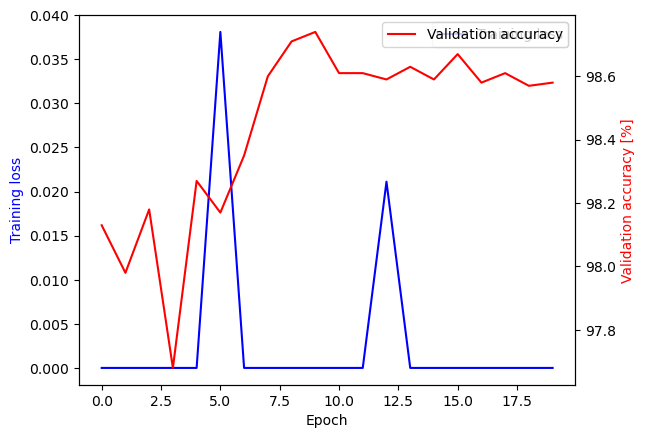

In [31]:
import matplotlib.pyplot as plt

epoch_cutoff = 20

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()

# Plot data on the primary y-axis
ax1.plot(loss_history, color='blue', label='Training loss')
ax1.set_ylabel('Training loss', color='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data on the secondary y-axis
ax2.plot(accuracy_history, color='red', label='Validation accuracy')
ax2.set_ylabel('Validation accuracy [%]', color='red')

# Add legend
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel("Epoch")
# Show plot
plt.show()